<a href="https://colab.research.google.com/github/rudraymehra/RESS-Attrition-Prediction/blob/main/HRassistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00


In [ ]:
import os, pandas as pd, numpy as np
from datetime import datetime
from dateutil import parser

# 📁 PATH SETUP
BASE = os.getcwd()
DATA = os.path.join(BASE, "data", "raw")
MODELS = os.path.join(BASE, "models")

os.makedirs(DATA, exist_ok=True)
os.makedirs(MODELS, exist_ok=True)

# 📂 LOAD DATA
merged_path = os.path.join(BASE, "train_data_merged_all_columns.csv")
train = pd.read_csv(merged_path)
print("✅ Data loaded successfully.")
print(train.head())

# 🎯 BUILD TARGET VARIABLE
y = (pd.to_datetime(train["LastWorkingDate"], errors="coerce").notna()).astype(int)

# 🧮 ROBUST DATE PARSING FOR 'MMM-YY'
def parse_mmm_yy(x):
    """Parse various MMM-YY or YYYY-MM formats robustly."""
    if pd.isna(x):
        return pd.NaT
    x = str(x).strip()
    # Try multiple common date formats
    for fmt in ("%b-%y", "%b-%Y", "%B-%y", "%B-%Y", "%Y-%m", "%Y-%b"):
        try:
            return datetime.strptime(x, fmt)
        except Exception:
            continue
    # Fallback: flexible parser (handles 'Jan 2020', '2020/01', etc.)
    try:
        return parser.parse(x, fuzzy=True)
    except Exception:
        return pd.NaT

# Apply date parsing
snap_dt = train["MMM-YY"].apply(parse_mmm_yy)
doj_dt = pd.to_datetime(train["Dateofjoining"], errors="coerce")

# 🧮 TENURE FEATURES (leakage-free)
def tenure_months(snap, doj):
    if pd.isna(snap) or pd.isna(doj):
        return np.nan
    return (snap.year - doj.year) * 12 + (snap.month - doj.month)

train["tenure_months_snap"] = [tenure_months(s, d) for s, d in zip(snap_dt, doj_dt)]
train["tenure_years"] = train["tenure_months_snap"] / 12

# 💡 EXTRA ENGINEERED FEATURES
if "Salary" in train.columns:
    # Salary per year of experience (avoid div-by-zero)
    train["Salary_per_Year"] = train["Salary"] / (train["tenure_years"].replace(0, np.nan) + 0.1)

    # High-salary flag
    salary_median = train["Salary"].median(skipna=True)
    train["is_high_salary"] = (train["Salary"] > salary_median).astype(int)

# City frequency encoding
if "City" in train.columns:
    city_freq = train["City"].value_counts(normalize=True)
    train["City_freq"] = train["City"].map(city_freq)

# Recent joiner (worked < 12 months)
train["recent_joiner"] = (train["tenure_months_snap"] < 12).astype(int)

# 🧹 CLEANUP & FEATURE SELECTION
drop_cols = ["Emp_ID", "MMM-YY", "Dateofjoining", "LastWorkingDate"]
feat_cols = [c for c in train.columns if c not in drop_cols and c != "Attrition"]

X_train_raw = train[feat_cols].copy()

# Clean residual NaNs
num_cols = X_train_raw.select_dtypes(include=[np.number]).columns
cat_cols = X_train_raw.select_dtypes(exclude=[np.number]).columns

X_train_raw[num_cols] = X_train_raw[num_cols].apply(pd.to_numeric, errors='coerce')
X_train_raw[num_cols] = X_train_raw[num_cols].fillna(X_train_raw[num_cols].median())
X_train_raw[cat_cols] = X_train_raw[cat_cols].fillna("Unknown")

# ✅ SUMMARY
print("\n✅ Feature engineering complete!")
print("y shape:", y.shape, "| positives (left=1):", int(y.sum()))
print("X_train_raw shape:", X_train_raw.shape)
print("First 10 columns:", X_train_raw.columns[:10].tolist())
print("\nSample rows:")
print(X_train_raw.head(3))

✅ Data loaded successfully.
       MMM-YY  Emp_ID  Age  Gender City Education_Level  Salary Dateofjoining  \
0  2017-05-01     228   45    Male   C6          Master   53385    2013-07-25   
1  2016-02-01     995   31    Male  C17        Bachelor   69418    2013-05-01   
2  2017-06-01    1033   27    Male  C12         College   41705    2016-11-16   
3  2016-05-01     171   44  Female  C23        Bachelor   56242    2015-08-24   
4  2016-02-01     652   33    Male  C20        Bachelor  112322    2015-11-05   

  LastWorkingDate  Joining Designation  Designation  Total Business Value  \
0      2017-05-01                    1            1                     0   
1             NaN                    1            3                229480   
2             NaN                    1            1                     0   
3             NaN                    2            2                     0   
4             NaN                    4            4                     0   

   Quarterly Rating  


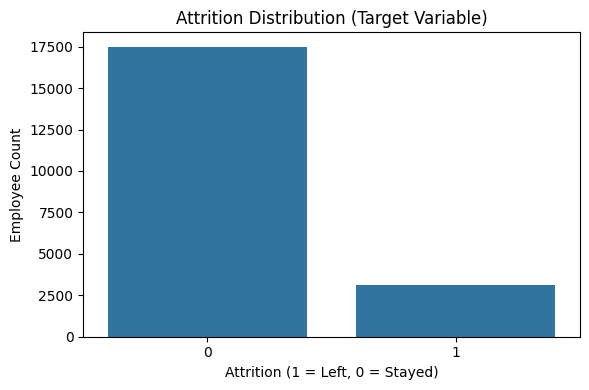

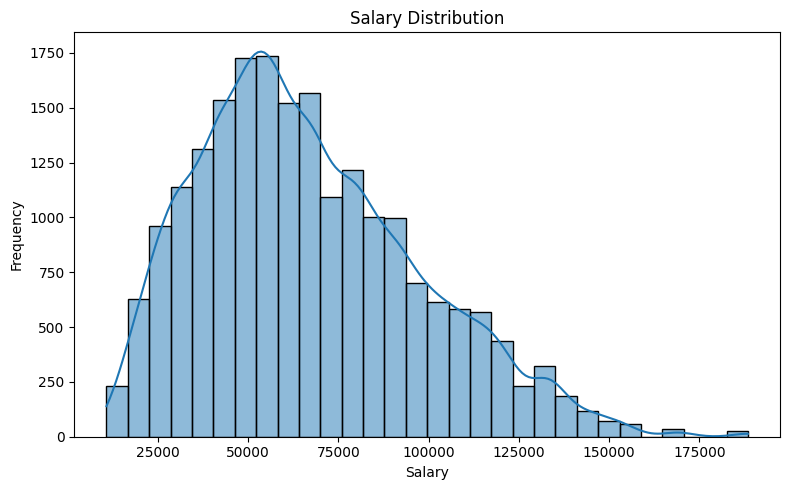

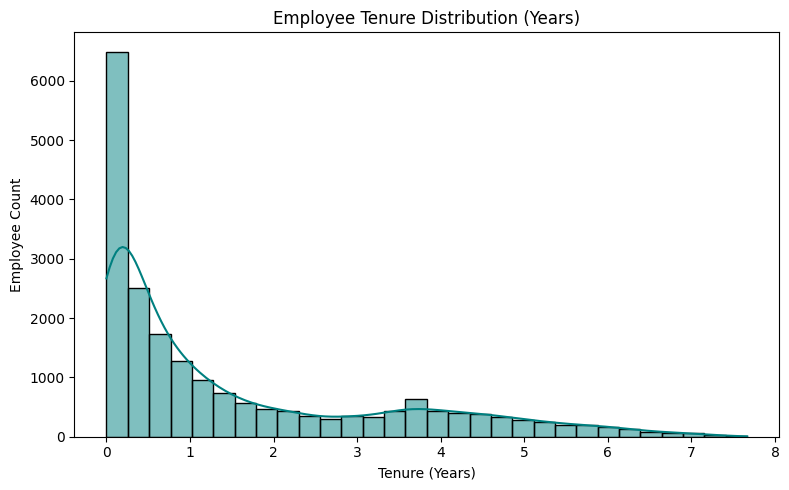

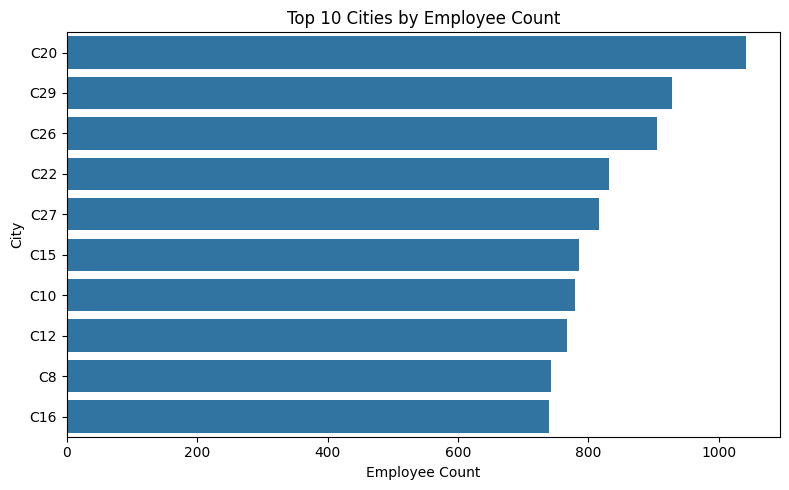

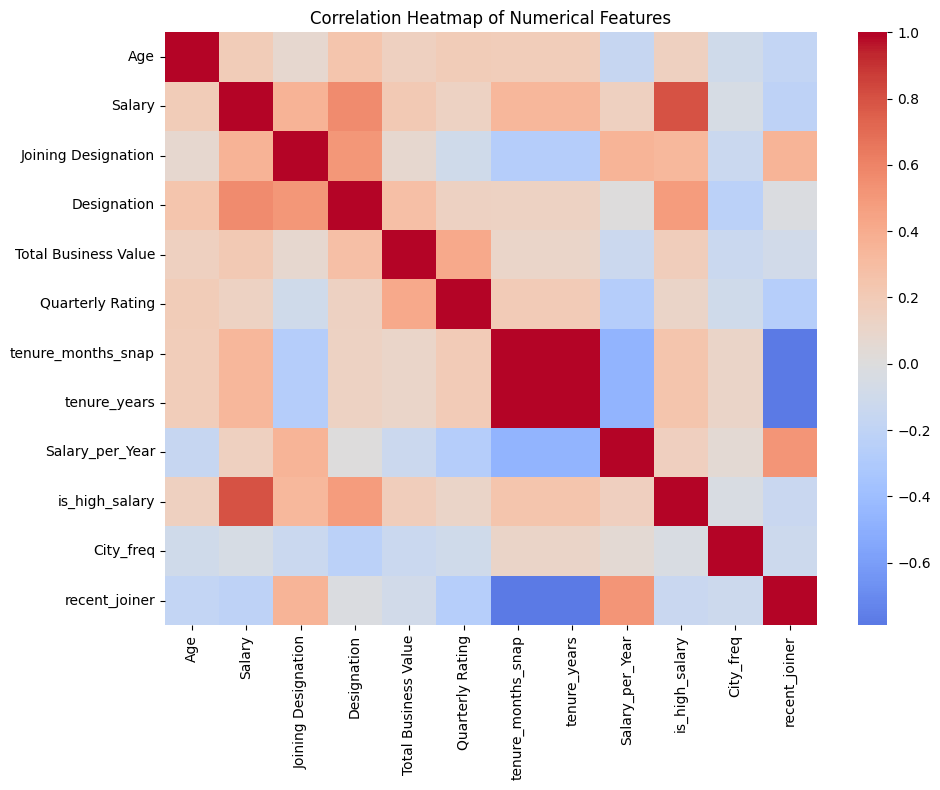

/tmp/ipython-input-1418805429.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train["recent_joiner"], y=train["Salary"], palette="viridis")


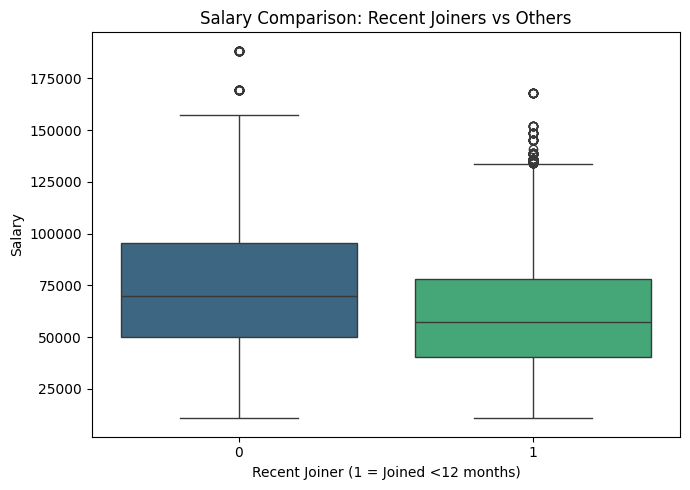

In [ ]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

# 1️⃣ Target Distribution (Attrition)
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Attrition Distribution (Target Variable)")
plt.xlabel("Attrition (1 = Left, 0 = Stayed)")
plt.ylabel("Employee Count")
plt.tight_layout()
plt.show()

# 2️⃣ Salary Distribution
if "Salary" in train.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(train["Salary"], bins=30, kde=True)
    plt.title("Salary Distribution")
    plt.xlabel("Salary")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# 3️⃣ Tenure Distribution
plt.figure(figsize=(8,5))
sns.histplot(train["tenure_years"], bins=30, kde=True, color="teal")
plt.title("Employee Tenure Distribution (Years)")
plt.xlabel("Tenure (Years)")
plt.ylabel("Employee Count")
plt.tight_layout()
plt.show()

# 4️⃣ City-wise Employee Distribution
if "City" in train.columns:
    top_cities = train["City"].value_counts().head(10)
    plt.figure(figsize=(8,5))
    sns.barplot(x=top_cities.values, y=top_cities.index, orient="h")
    plt.title("Top 10 Cities by Employee Count")
    plt.xlabel("Employee Count")
    plt.ylabel("City")
    plt.tight_layout()
    plt.show()

# 5️⃣ Correlation Heatmap (Numerical Features)
plt.figure(figsize=(10,8))
corr = X_train_raw[num_cols].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

# 6️⃣ Recent Joiners vs Salary (Insight Example)
if "Salary" in train.columns:
    plt.figure(figsize=(7,5))
    sns.boxplot(x=train["recent_joiner"], y=train["Salary"], palette="viridis")
    plt.title("Salary Comparison: Recent Joiners vs Others")
    plt.xlabel("Recent Joiner (1 = Joined <12 months)")
    plt.ylabel("Salary")
    plt.tight_layout()
    plt.show()

In [ ]:
# ============================================
# STEP 2 — Smarter cleaning + encoding
# ============================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from category_encoders.target_encoder import TargetEncoder

# 0️⃣ Ensure base variables exist
# (Re-run Step 1 before this if needed)
assert 'X_train_raw' in locals() and 'y' in locals(), "Please run Step 1 first"

# 1️⃣ Remove duplicate columns
X_train_raw = X_train_raw.loc[:, ~X_train_raw.columns.duplicated()].copy()

# 2️⃣ Identify categorical vs numeric features
cat_cols = [c for c in X_train_raw.columns if X_train_raw[c].dtype == "object"]
num_cols = [c for c in X_train_raw.columns if c not in cat_cols]

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

# 3️⃣ Convert numeric and impute with median (robust to outliers)
for c in num_cols:
    X_train_raw[c] = pd.to_numeric(X_train_raw[c], errors="coerce")

train_medians = X_train_raw[num_cols].median()
X_train_raw[num_cols] = X_train_raw[num_cols].fillna(train_medians)

# 4️⃣ Fill missing categoricals
for c in cat_cols:
    X_train_raw[c] = X_train_raw[c].fillna("Unknown")

# 5️⃣ Target encode categoricals (smarter than one-hot)
if len(cat_cols) > 0:
    te = TargetEncoder(cols=cat_cols, smoothing=0.2)
    X_train_enc = te.fit_transform(X_train_raw, y)
else:
    X_train_enc = X_train_raw.copy()

# 6️⃣ Scale numeric features (helps gradient-based models)
scaler = StandardScaler()
X_train_enc[num_cols] = scaler.fit_transform(X_train_enc[num_cols])

print(f"\n✅ Encoding complete.")
print("Preview:")
X_train_enc.head(3)

Categorical columns: ['Gender', 'City', 'Education_Level']
Numeric columns: ['Age', 'Salary', 'Joining Designation', 'Designation', 'Total Business Value', 'Quarterly Rating', 'tenure_months_snap', 'tenure_years', 'Salary_per_Year', 'is_high_salary', 'City_freq', 'recent_joiner']

✅ Encoding complete.
Preview:


,Age,Gender,City,Education_Level,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,tenure_months_snap,tenure_years,Salary_per_Year,is_high_salary,City_freq,recent_joiner
0,1.431621,0.141952,0.120640,0.151995,-0.434790,-0.823482,-0.983556,-0.501773,-1.004611,1.293563,1.293563,-0.730253,-0.999903,-0.023264,-1.136385
1,-0.594161,0.141952,0.186047,0.142722,0.088555,-0.823482,0.335620,-0.335073,-1.004611,0.682841,0.682841,-0.621943,1.000097,-1.220783,-1.136385
2,-1.172956,0.141952,0.121252,0.091662,-0.816046,-0.823482,-0.983556,-0.501773,-1.004611,-0.538603,-0.538603,-0.253627,-0.999903,0.416755,0.879984


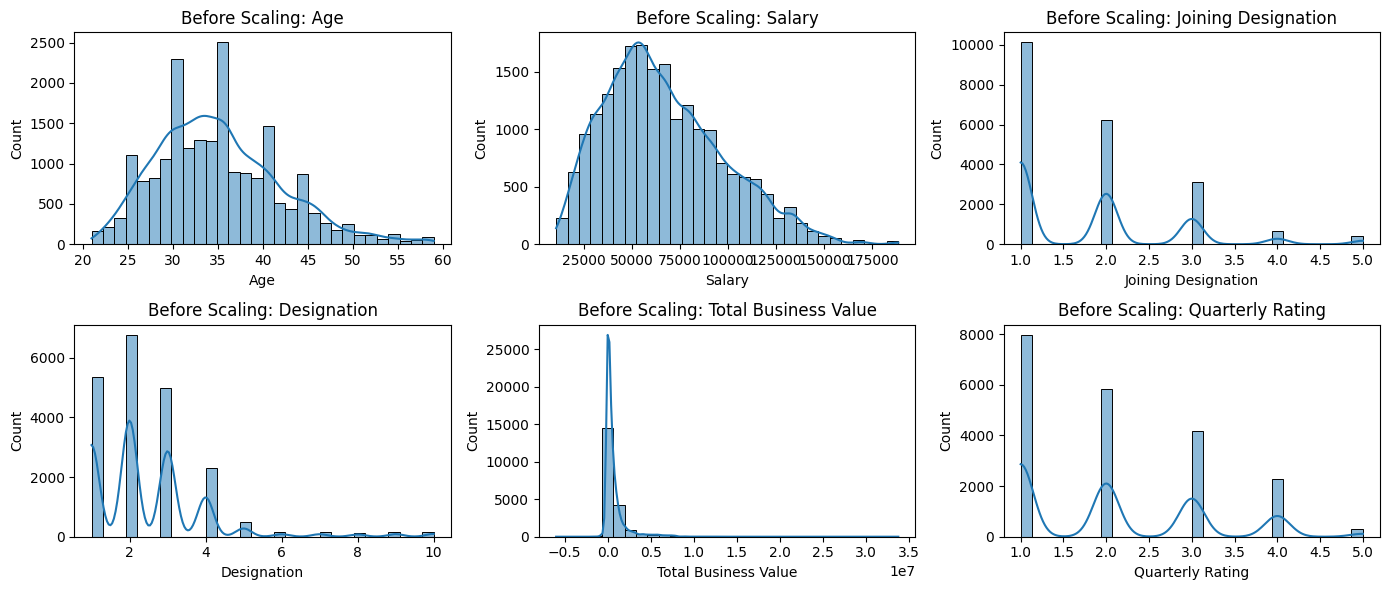

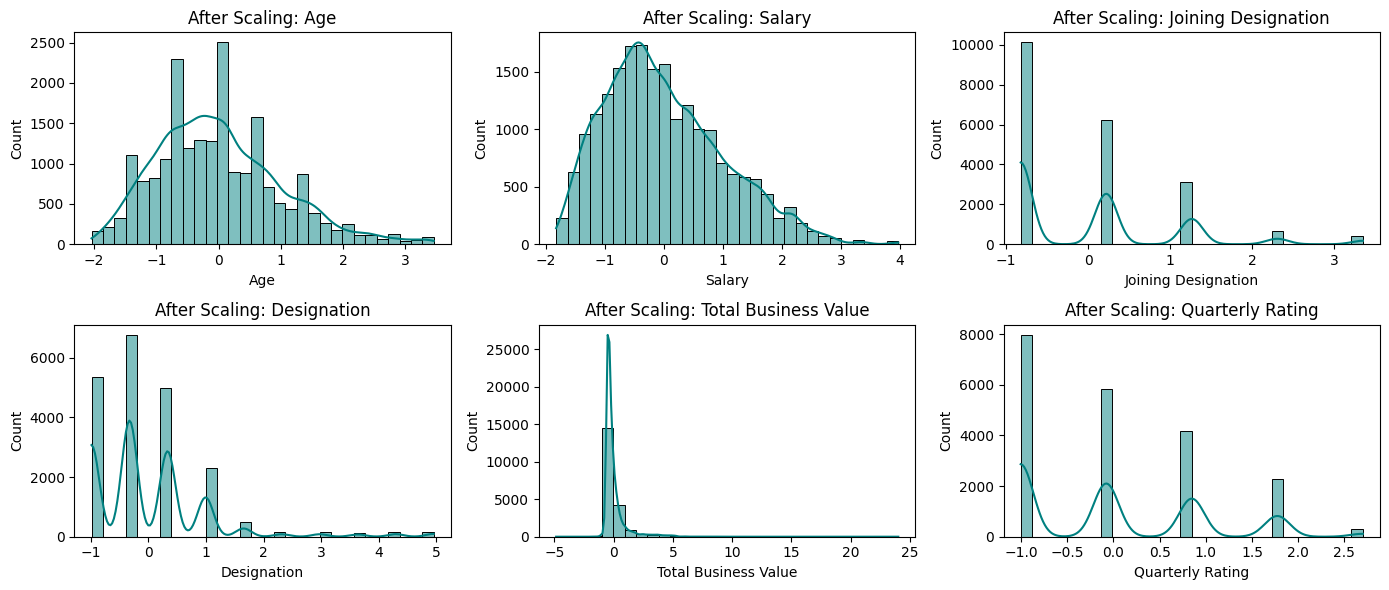

In [ ]:
plt.figure(figsize=(14, 6))
for i, col in enumerate(num_cols[:6]):  # limit to first 6 numeric features
    plt.subplot(2, 3, i + 1)
    sns.histplot(X_train_raw[col], kde=True, bins=30)
    plt.title(f"Before Scaling: {col}")
plt.tight_layout()
plt.show()

# 5️⃣ Target encode categoricals
if len(cat_cols) > 0:
    te = TargetEncoder(cols=cat_cols, smoothing=0.2)
    X_train_enc = te.fit_transform(X_train_raw, y)
else:
    X_train_enc = X_train_raw.copy()

# 6️⃣ Scale numeric features
scaler = StandardScaler()
X_train_enc[num_cols] = scaler.fit_transform(X_train_enc[num_cols])

plt.figure(figsize=(14, 6))
for i, col in enumerate(num_cols[:6]):
    plt.subplot(2, 3, i + 1)
    sns.histplot(X_train_enc[col], kde=True, bins=30, color="teal")
    plt.title(f"After Scaling: {col}")
plt.tight_layout()
plt.show()

In [ ]:
# ✅ LEAKAGE-FREE MODEL TRAINING PIPELINE (with Precision)
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, roc_auc_score
)
from sklearn.preprocessing import StandardScaler
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

# 1️⃣ Separate numeric and categorical
cat_cols = [c for c in X_train_raw.columns if X_train_raw[c].dtype == 'object']
num_cols = [c for c in X_train_raw.columns if c not in cat_cols]

# 2️⃣ Convert to numeric, impute missing values
for c in num_cols:
    X_train_raw[c] = pd.to_numeric(X_train_raw[c], errors="coerce")
X_train_raw[num_cols] = X_train_raw[num_cols].fillna(X_train_raw[num_cols].median())

# 3️⃣ Fill missing categorical with 'Unknown'
for c in cat_cols:
    X_train_raw[c] = X_train_raw[c].fillna("Unknown")

# 4️⃣ Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

# 5️⃣ Cross-validated loop (NO LEAKAGE)
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_raw, y), 1):
    print(f"\n🔹 Fold {fold} =========================")

    X_tr, X_val = X_train_raw.iloc[train_idx].copy(), X_train_raw.iloc[val_idx].copy()
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # --- Encode categoricals inside fold (no target leakage) ---
    if len(cat_cols) > 0:
        te = TargetEncoder(cols=cat_cols, smoothing=0.3)
        X_tr = te.fit_transform(X_tr, y_tr)
        X_val = te.transform(X_val)
    else:
        X_tr, X_val = X_tr.copy(), X_val.copy()

    # --- Scale numeric features ---
    scaler = StandardScaler()
    X_tr[num_cols] = scaler.fit_transform(X_tr[num_cols])
    X_val[num_cols] = scaler.transform(X_val[num_cols])

    # 🔧 Fix any NaNs from encoding/scaling
    train_medians = X_tr.median()
    X_tr = X_tr.fillna(train_medians)
    X_val = X_val.fillna(train_medians)

    # Logistic Regression (baseline)
    logreg = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)
    logreg.fit(X_tr, y_tr)
    p_val = logreg.predict_proba(X_val)[:, 1]
    y_pred = (p_val >= 0.5).astype(int)

    log_acc  = accuracy_score(y_val, y_pred)
    log_prec = precision_score(y_val, y_pred)
    log_f1   = f1_score(y_val, y_pred)
    log_auc  = roc_auc_score(y_val, p_val)

    # XGBoost Classifier
    xgb = XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        min_child_weight=4,
        eval_metric='auc',
        scale_pos_weight=(1 - y_tr.mean()) / y_tr.mean(),
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(X_tr, y_tr)
    p_xgb = xgb.predict_proba(X_val)[:, 1]
    yhat_xgb = (p_xgb >= 0.5).astype(int)

    xgb_acc  = accuracy_score(y_val, yhat_xgb)
    xgb_prec = precision_score(y_val, yhat_xgb)
    xgb_f1   = f1_score(y_val, yhat_xgb)
    xgb_auc  = roc_auc_score(y_val, p_xgb)

    # CatBoost Classifier
    cat = CatBoostClassifier(
        iterations=600,
        learning_rate=0.05,
        depth=6,
        eval_metric='AUC',
        scale_pos_weight=(1 - y_tr.mean()) / y_tr.mean(),
        random_seed=42,
        verbose=0
    )
    cat.fit(X_tr, y_tr)
    p_cat = cat.predict_proba(X_val)[:, 1]
    yhat_cat = (p_cat >= 0.5).astype(int)

    cat_acc  = accuracy_score(y_val, yhat_cat)
    cat_prec = precision_score(y_val, yhat_cat)
    cat_f1   = f1_score(y_val, yhat_cat)
    cat_auc  = roc_auc_score(y_val, p_cat)

    # Collect results
    cv_results.extend([
        {"fold": fold, "Model": "LogisticRegression",
         "Accuracy": log_acc, "Precision": log_prec, "F1": log_f1, "ROC-AUC": log_auc},
        {"fold": fold, "Model": "XGBoost",
         "Accuracy": xgb_acc, "Precision": xgb_prec, "F1": xgb_f1, "ROC-AUC": xgb_auc},
        {"fold": fold, "Model": "CatBoost",
         "Accuracy": cat_acc, "Precision": cat_prec, "F1": cat_f1, "ROC-AUC": cat_auc}
    ])

# Summary Table
df_cv = pd.DataFrame(cv_results)
summary = (
    df_cv.groupby("Model")[["Accuracy", "Precision", "F1", "ROC-AUC"]]
    .mean()
    .sort_values(by="ROC-AUC", ascending=False)
)

print("\n✅ Cross-Validation Results (Leakage-Free):\n")
print(summary.round(4))


🔹 Fold 1 =========================

🔹 Fold 2 =========================

🔹 Fold 3 =========================

🔹 Fold 4 =========================

🔹 Fold 5 =========================

✅ Cross-Validation Results (Leakage-Free):

                    Accuracy  Precision      F1  ROC-AUC
Model                                                   
CatBoost              0.8860     0.5854  0.6916   0.9371
XGBoost               0.8854     0.5845  0.6883   0.9344
LogisticRegression    0.7694     0.3652  0.4823   0.8406


/tmp/ipython-input-1327418914.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_cv, x="Model", y="ROC-AUC", ci=None, hue="Model", dodge=False)


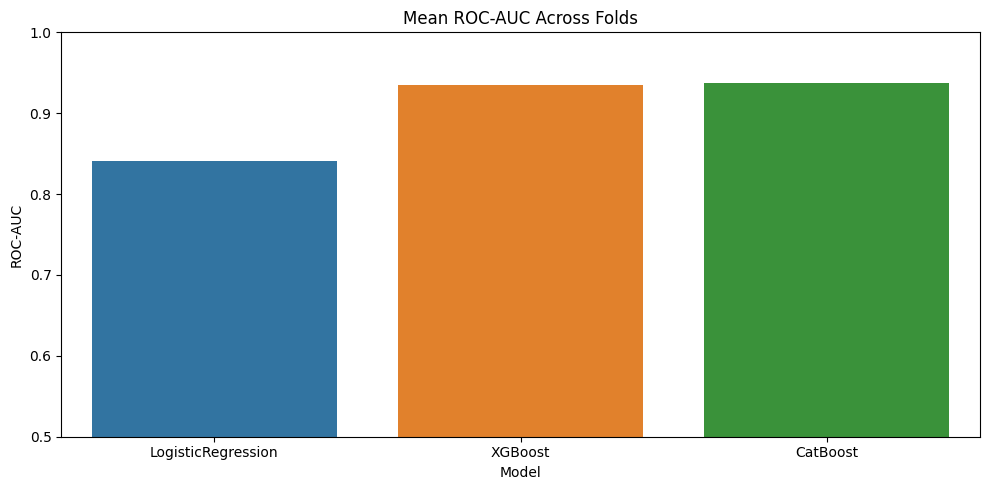

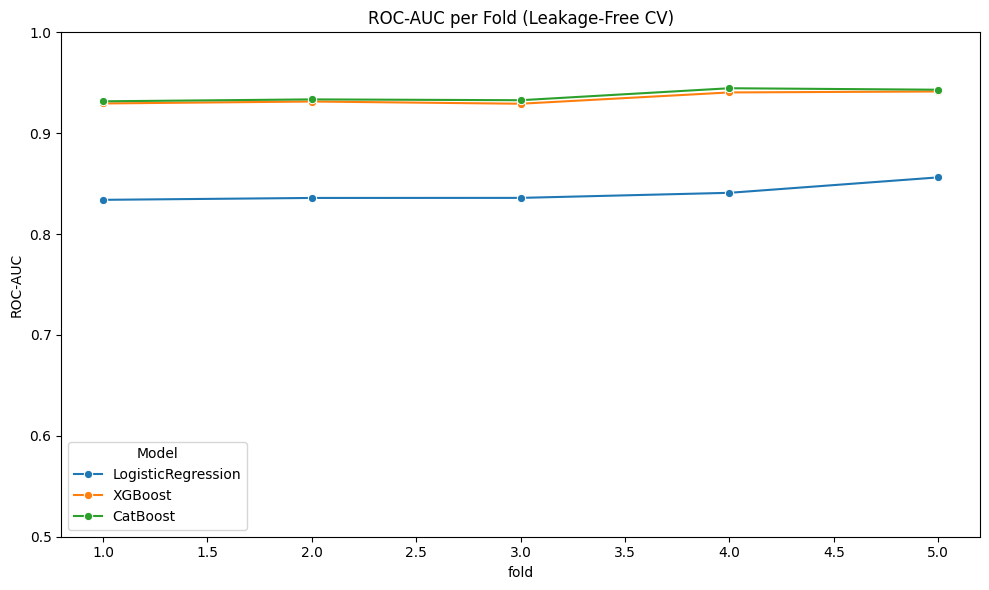

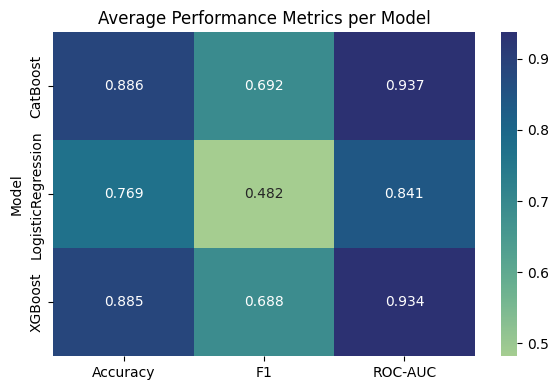

In [ ]:
# Overall Model Comparison (Bar Plot)
plt.figure(figsize=(10,5))
sns.barplot(data=df_cv, x="Model", y="ROC-AUC", ci=None, hue="Model", dodge=False)
plt.title("Mean ROC-AUC Across Folds")
plt.ylabel("ROC-AUC")
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()

# Fold-wise ROC-AUC trend
plt.figure(figsize=(10,6))
sns.lineplot(data=df_cv, x="fold", y="ROC-AUC", hue="Model", marker="o")
plt.title("ROC-AUC per Fold (Leakage-Free CV)")
plt.ylabel("ROC-AUC")
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()

# Summary Heatmap of Metrics
pivot = df_cv.groupby("Model")[["Accuracy", "F1", "ROC-AUC"]].mean().round(3)
plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, cmap="crest", fmt=".3f")
plt.title("Average Performance Metrics per Model")
plt.tight_layout()
plt.show()